In [90]:
# PyTorch core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seed
torch.manual_seed(123)

# Pre-trained models and transforms from torchvision
from torchvision import models
from torchvision.transforms import v2

# Data loading utilities
from data import getDataLoaders, getClassNames

# Utility libraries
from collections import OrderedDict
import datetime
import os
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# TensorBoard for logging
from torch.utils.tensorboard import SummaryWriter

# Confusion matrix tools from sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
# Load the ResNet-18 model from pytorch and display its architecture 
device = "cuda" if torch.cuda.is_available else "cpu"
resnet18 = models.resnet18(weights='DEFAULT').to(device)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In this pre-trained ResNet model, two key adjustments need to be made: the first and last layers. ResNet was originally trained on the ImageNet dataset, which consists of images that are 224x224 pixels and classified into a thousand categories. Here are the two main issues and their solutions:

1) **Input image size and normalization**: Pre-trained models expect input images to be normalized in a specific way, with mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are at least 224 pixels (cf [PyTorch ResNet Documentation](https://pytorch.org/hub/pytorch_vision_resnet/)). Moreover, the model expects the input images to be normalized with the following mean and standard deviation values (calculated from ImageNet data):
    - `mean = [0.485, 0.456, 0.406]`
    - `std = [0.229, 0.224, 0.225]`
   
***Solution***: Since CIFAR-10 images are 32x32 pixels, we can either resize them to match the pre-trained model's input size or adapt the first layer to fit the smaller input. Resizing to 224x224 can cause distortion, loss of detail, and significantly increase computation time due to the larger input size. Instead, modifying the first layer with a smaller 3x3 kernel is more efficient, preserving details and reducing computational cost compared to the original 7x7 kernel. We also omit the maxpool layer since its pooling operation is unnecessary for such small images.

2) **Output layer**: The final fully connected layer, `(fc): Linear(in_features=512, out_features=1000, bias=True)`, is designed to output 1,000 features, corresponding to the 1,000 classes of ImageNet. 

***Solution***: The CIFAR-10 dataset has 10 different classes. Therefore, we need to adjust the `out_features` parameter in the final fully connected layer: `(fc): Linear(in_features=512, out_features=10, bias=True).`

In [4]:
class ResNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()

        self.model = models.resnet18(weights=weights)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

    def forward(self, x):
        return self.model(x)

Initially, we will test the model with default weights. Consequently, we should use the provided normalization values since the model was originally trained on a different dataset, and these values help ensure the input is consistent with what the model expects.

In [5]:
default_net = ResNet(weights='DEFAULT')

# Normalize images using ImageNet's mean and std values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

imageNet_processing = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

train_loader, val_loader = getDataLoaders(transform=imageNet_processing)
train_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/cifar-10-batches-py/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [26]:
def model_accuracy(model, train_loader, val_loader, device):
    model = model.to(device=device)
    model.eval()
    for name, loader in zip((['train', 'val']), ([train_loader, val_loader])):
        correct = 0
        count = torch.zeros(10).to(device)
        total = len(loader.dataset)
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
           
            with torch.inference_mode():
                outputs = model(imgs)
                pred = torch.argmax(outputs, dim=1)
            correct += int((pred == labels).sum())
            count += torch.bincount(pred, minlength=10)

        print(f"Score {name}: {correct} / {total}",
              f"\nAccuracy {name}: {(correct / total)*100:.2f}%",
              f"\nDistribution {name} (in %): [{', '.join([f'{(c / total * 100):.2f}' for c in count])}]")

        print()

In [32]:
model_accuracy(
    model=default_net,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Score train: 4776 / 50000 
Accuracy train: 9.55% 
Distribution train (in %): [27.09, 0.60, 47.95, 4.56, 0.04, 0.04, 2.12, 15.90, 0.09, 1.61]

Score val: 987 / 10000 
Accuracy val: 9.87% 
Distribution val (in %): [26.11, 0.47, 49.03, 4.39, 0.02, 0.06, 2.34, 15.72, 0.10, 1.76]



As expected, the model needs to be trained properly to produce meaningful results on the CIFAR-10 dataset. Applying basic transformations alone isn’t enough. The current accuracy of 10% suggests that the model is effectively making random guesses, as we'd expect from choosing a class purely by chance.

More interestingly, the class distribution reveals a clear bias. The model is heavily favoring certain classes while barely predicting others.

Now, let's train the model on the CIFAR-10 dataset.

In [6]:
# CIFAR-10 normalization
train_loader, val_loader = getDataLoaders()
train_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/cifar-10-batches-py/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[tensor(0.4914), tensor(0.4822), tensor(0.4465)], std=[tensor(0.2470), tensor(0.2435), tensor(0.2616)], inplace=False)
           )

In [2]:
def training_loop(n_epochs, loader, model, optimizer, loss_fn, device):
    model = model.to(device)

    # Loss is computed over batches, accuracy is computed over individual items
    total_items = len(loader.dataset)
    total_batches = len(loader)
    
    for epoch in range(1, n_epochs + 1):
        model.train()  
        loss_train = 0.0
        correct = 0
        total = 0 

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            logits = model(imgs)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()

        average_loss = loss_train / total_batches
        accuracy = (correct / total_items) * 100  
        
        print(f"Epoch [{epoch}/{n_epochs}]: Loss_train = {average_loss:.4f}, Accuracy = {accuracy:.2f}%")

In [41]:
cifar_net = ResNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net.parameters(), lr=0.01, momentum=0.9)
training_loop(
    n_epochs=10,
    loader=train_loader,
    model=cifar_net, 
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)
torch.save(cifar_net.state_dict(), './models/ResNet18/resnet18.pth')

Epoch [1/10]: Loss_train = 1.3659, Accuracy = 50.54%, Total = 50000, LenLoader = 782
Epoch [2/10]: Loss_train = 0.8366, Accuracy = 70.56%, Total = 50000, LenLoader = 782


KeyboardInterrupt: 

In [38]:
model = ResNet()
model.load_state_dict(torch.load('./models/ResNet18/resnet18.pth'))
model_accuracy(
    model=cifar_net,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Score train: 49586 / 50000 
Accuracy train: 99.17% 
Distribution train (in %): [10.33, 9.98, 9.85, 9.77, 9.91, 10.10, 10.00, 10.16, 9.91, 9.97]

Score val: 7947 / 10000 
Accuracy val: 79.47% 
Distribution val (in %): [13.31, 10.45, 7.85, 7.89, 8.94, 10.87, 9.99, 12.16, 8.98, 9.56]



The results are good considering only 10 epochs of training and minimal modifications! The distribution is as expected, with approximately 10% for each class. However, there is noticeable overfitting: the model's accuracy on the training set reaches about 98%, while its accuracy on the validation set drops below 80%.

From now on, we will test multiple models to prevent overfitting. To clearly visualize the performance of each model, we will use TensorBoard.

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        if downsample:
            self.downsample = nn.Sequential(OrderedDict([
                                  ('conv3', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, bias=False)),
                                  ('bn3', nn.BatchNorm2d(num_features=out_channels)),
                                ]))
        else:
            self.downsample = None

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        #  If downsampling is applied, we need to adjust the residual's dimensions
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual

        return self.relu(out)

In [8]:
class ResNetLayer(nn.Module):
    def __init__(self, layers, out_channels=64, dropout=0):
        super().__init__()
        self.in_channels = out_channels
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layers = nn.ModuleDict()

        # Creation of the layers 
        for num_layer in range(1, layers+1):
            # No downsampling in the first layer
            downsample = True if num_layer > 1 else False

            layer_name = f'layer{num_layer}'
            layer = self.make_layer(downsample)
            self.layers[layer_name] = layer

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=self.in_channels, out_features=10)
        self.dropout = nn.Dropout(p=dropout) if dropout else None
        
    def make_layer(self, downsample):
        if downsample:
            layer = nn.Sequential(OrderedDict([
                ('block1', BasicBlock(in_channels=self.in_channels, out_channels=self.in_channels*2, downsample=True)),
                ('block2', BasicBlock(in_channels=self.in_channels*2, out_channels=self.in_channels*2))
            ]))
            # Update in_channels after downsampling
            self.in_channels *= 2
        else:
            layer = nn.Sequential(OrderedDict([
                ('block1', BasicBlock(in_channels=self.in_channels, out_channels=self.in_channels)),
                ('block2', BasicBlock(in_channels=self.in_channels, out_channels=self.in_channels))
            ]))

        return layer

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        for _, layer in self.layers.items():
            out = layer(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        
        if self.dropout:
            out = self.dropout(out)
        
        return out

    def predict(self, x):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        class_names = getClassNames()

        with torch.inference_mode():
            self.eval()
            self = self.to(device)
            x = x.to(device)
            
            logits = self(x)
            pred = torch.argmax(logits, dim=1)
            probs = F.softmax(logits, dim=1)

            probs_np = probs.cpu().numpy()
            dict_probs = {class_names[i]: f"{prob*100:.2f}" for i, prob in enumerate(probs_np[0])} # probs_np.shape = [1, 10]

            class_pred = class_names[pred.item()]
        return class_pred, dict_probs
        

In [10]:
def train_model(n_epochs, model, train_loader, val_loader, loss_fn, optimizer, device, log_dir="./runs"):
    # TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)
    
    total_train_batches = len(train_loader)
    total_train_items = len((train_loader.dataset)

    total_val_batches = len(val_loader)                    
    total_val_items = len(val_loader.dataset)
    
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        # Loss/train metric
        loss_train = 0.0
        # Acc/train metric
        correct_train = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            logits = model(imgs)
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct_train += (predicted == labels).sum().item()
            
        total_loss_train = loss_train / total_train_batches
        total_acc_train = (correct_train / total_train_items) * 100 

        model.eval()
        # Loss/val metric
        loss_val = 0.0
        # Loss/accuracy metric
        correct_val = 0

        with torch.inference_mode():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                
                logits = model(imgs)
                loss = loss_fn(logits, labels)

                loss_val += loss.item()
                predicted = torch.argmax(logits, dim=1)
                correct_val += (predicted == labels).sum().item()

        total_loss_val = loss_val / total_val_batches
        total_acc_val = (correct_val / total_val_items) * 100

        writer.add_scalar('Loss/train', total_loss_train, epoch)
        writer.add_scalar('Accuracy/train', total_acc_train, epoch)
        writer.add_scalar('Loss/validation', total_loss_val, epoch)
        writer.add_scalar('Accuracy/validation', total_acc_val, epoch)

        print(f'Epoch [{epoch+1}/{n_epochs}]')
        print(f'Train Loss: {total_loss_train:.4f}, Train Accuracy: {total_acc_train:.2f}%')
        print(f'Validation Loss: {total_loss_val:.4f}, Validation Accuracy: {total_acc_val:.2f}%')

    writer.close()

In [41]:
# Example of a loop used to train multiple models sequentially

device = "cuda" if torch.cuda.is_available else "cpu"
train_loader, val_loader = getDataLoaders()
loss_fn = nn.CrossEntropyLoss()

layers = list(range(6))
epochs = [10, 20, 30]
optimizers = [(optim.SGD, 1e-2), (optim.Adam, 1e-3)]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]

for layer, epoch, (opt, lr), dropout in itertools.product(layers, epochs, optimizers, dropouts):
    model = ResNetLayer(layer, dropout=dropout)
    model_name = f'{layer}-{epoch}-{opt.__name__}-{dropout}'
    optimizer = opt(model.parameters(), lr=lr)
    
    train_model(
        n_epochs=,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        log_dir=f'./runs/ResNet18/{model_name}'
    )
    
    torch.save(model.state_dict(), f'./models/ResNet18/{model_name}.pth')

In [40]:
train_loader, val_loader = getDataLoaders()
model = ResNetLayer(3) # No need to specify the dropout since we're making inferences
# Best model so far
model.load_state_dict(torch.load('./models/ResNet18/3-10-Adam-0.2.pth', weights_only=True))
model_accuracy(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Files already downloaded and verified
Files already downloaded and verified
Score train: 47893 / 50000 
Accuracy train: 95.79% 
Distribution train (in %): [10.74, 9.80, 10.35, 9.66, 9.77, 9.94, 9.97, 10.17, 9.79, 9.81]

Score val: 8597 / 10000 
Accuracy val: 85.97% 
Distribution val (in %): [11.36, 9.49, 10.52, 9.24, 10.01, 9.93, 10.10, 10.14, 9.61, 9.60]



After testing several configurations, it seems that the best performance is achieved with a 3-layer, 0.2p-dropout model trained for 10 epochs using the Adam optimizer without L2 regularization (see runs/ResNet18 on TensorBoard). However, the results are very close to each other, and we are still encountering issues with overfitting. This suggests that the model architecture may still be inefficient or that we should adjust the hyperparameters.

To approach the problem from a different perspective, we should first examine the **confusion matrix**.

In [42]:
def display_matrix(y_true, y_pred):
    class_names = getClassNames()
    
    y_true = [class_names[label] for label in y_true]
    y_pred = [class_names[pred] for pred in y_pred]
    
    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(include_values=True, cmap='inferno', ax=None, xticks_rotation=45)
    
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(7)
    fig.set_figheight(7) 

In [45]:
def get_predictions(model, loader, device):
    model = model.to(device)
    model.eval()  
    all_labels = []
    all_preds = []
    
    with torch.inference_mode():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            
            all_labels.extend(labels.cpu().numpy()) # Tensors must be on the cpu to be converted into numpy arrays
            all_preds.extend(preds.cpu().numpy()) 
    
    return all_labels, all_preds

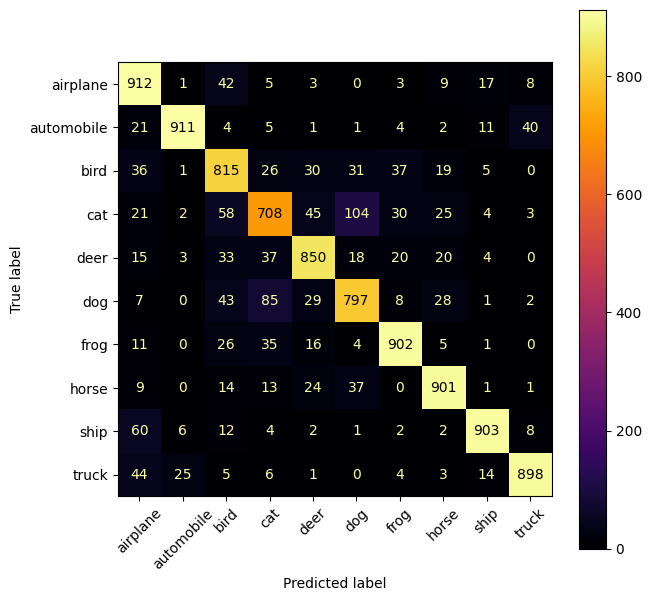

In [47]:
display_matrix(*get_predictions(model, val_loader, device))

We can now analyze our model's performance based on its confusion matrix. The model has achieved an overall accuracy of 86%, which is 6% better than the first version. However, it struggles to distinguish between cats and dogs. While it can generally differentiate animals from vehicles, there is still room for improvement in accurately identifying the various categories of animals and vehicles.

Let's see if the problem persists with another model.

In [50]:
def display_matrices(model_names, y_true1, y_pred1, y_true2, y_pred2):
    class_names = getClassNames()

    y_true1 = [class_names[label] for label in y_true1]
    y_pred1 = [class_names[class_pred] for class_pred in y_pred1]
    
    y_true2 = [class_names[label] for label in y_true2]
    y_pred2 = [class_names[class_pred] for class_pred in y_pred2]

    cm1 = confusion_matrix(y_true1, y_pred1, labels=class_names)
    cm2 = confusion_matrix(y_true2, y_pred2, labels=class_names)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=class_names)
    disp1.plot(include_values=True, cmap='inferno', ax=axes[0], xticks_rotation=45)
    axes[0].set_title(model_names[0])

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
    disp2.plot(include_values=True, cmap='inferno', ax=axes[1], xticks_rotation=45)
    axes[1].set_title(model_names[1])
    
    fig.set_figwidth(14)  
    fig.set_figheight(7) 
    
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


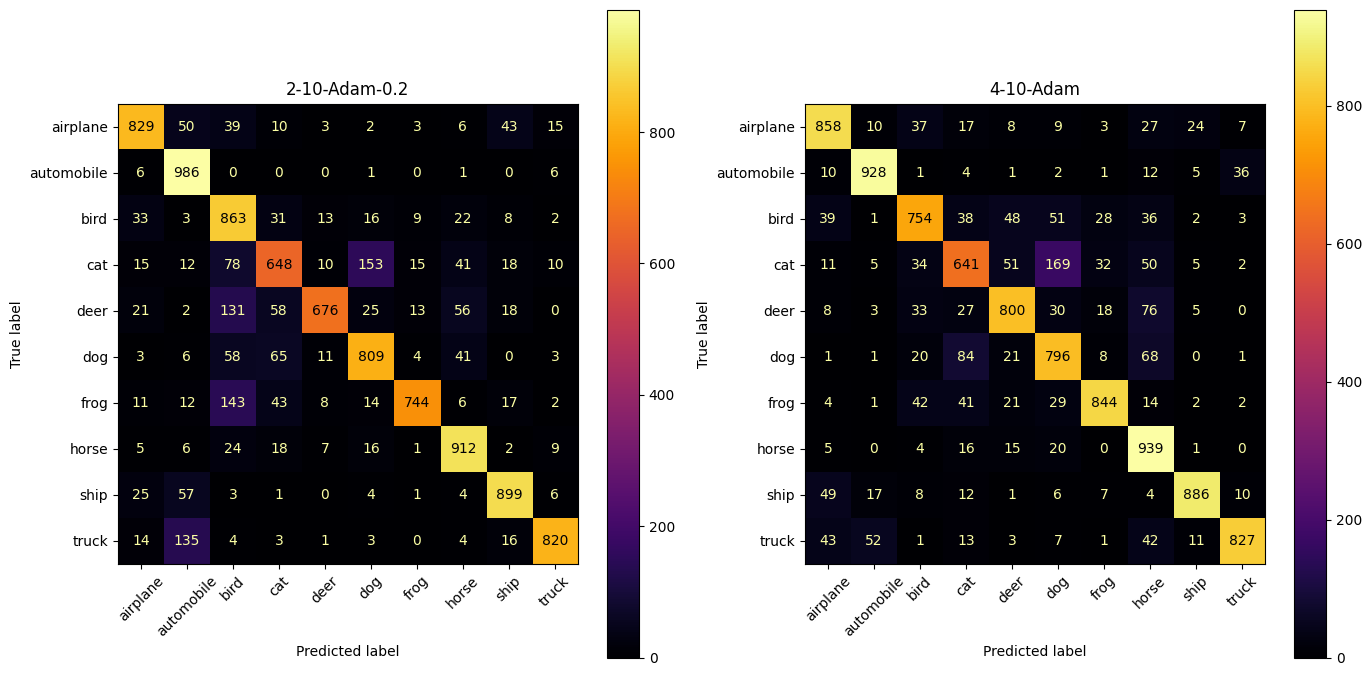

In [56]:
train_loader, val_loader = getDataLoaders()

model1 = ResNetLayer(2)
model1.load_state_dict(torch.load('./models/ResNet18/2-10-Adam-0.2.pth', weights_only=True))

model2 = ResNetLayer(4)
model2.load_state_dict(torch.load('./models/ResNet18/4-10-Adam.pth', weights_only=True))

model_names = ['2-10-Adam-0.2', '4-10-Adam']

display_matrices(model_names, *get_predictions(model1, val_loader, device), *get_predictions(model2, val_loader, device))

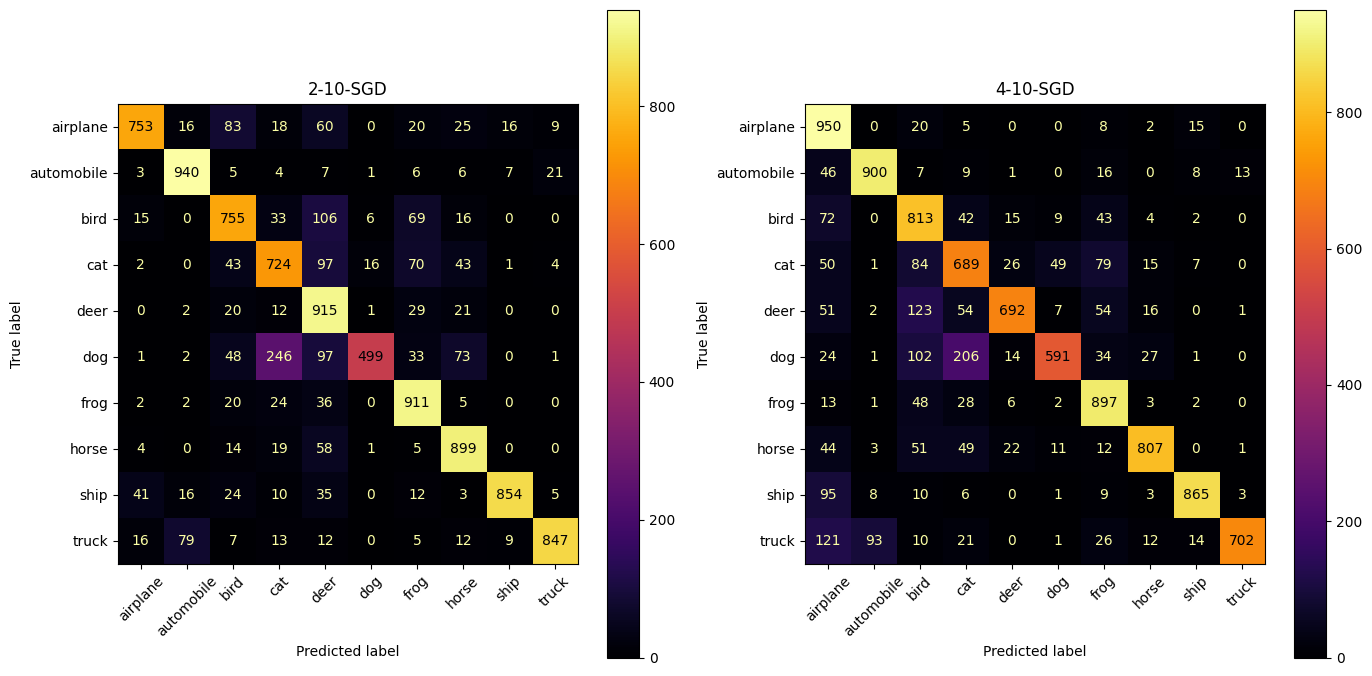

In [57]:
model1 = ResNetLayer(2)
model1.load_state_dict(torch.load('./models/ResNet18/2-10-SGD.pth', weights_only=True))

model2 = ResNetLayer(4)
model2.load_state_dict(torch.load('./models/ResNet18/4-10-SGD.pth', weights_only=True))

model_names = ['2-10-SGD', '4-10-SGD']

display_matrices(model_names, *get_predictions(model1, val_loader, device), *get_predictions(model2, val_loader, device))

At this point, it’s clear that, no matter what architecture the models have, telling cats and dogs apart is a real challenge. Given these results, we should focus on our data and use data augmentation techniques.

To save time, I found a data transformation online (cf [Data Preparation and Augmentation](https://medium.com/@thatchawin.ler/cifar10-with-resnet-in-pytorch-a86fe18049df)). Let’s check out the results.

In [108]:
# Processing found on the Internet 
internet_processing = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(20),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
    v2.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False),
])

In [17]:
train_loader, val_loader = getDataLoaders(transform=internet_processing)
device = "cuda" if torch.cuda.is_available else "cpu"

model = ResNetLayer(3, dropout=0.2)

# With this transformation, we can go up to 30 epochs of training.
model_name = f'3-30-Adam-0.2-InternetProcessing'
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(
    n_epochs=30,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    log_dir=f'./runs/ResNet18/{model_name}'
)

torch.save(model.state_dict(), f'./models/ResNet18/{model_name}.pth')

In [60]:
train_loader, val_loader = getDataLoaders()

model = ResNetLayer(3)
model.load_state_dict(torch.load('./models/ResNet18/3-30-Adam-0.2-InternetProcessing.pth', weights_only=True))
                      
model_accuracy(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Files already downloaded and verified
Files already downloaded and verified
Score train: 48201 / 50000 
Accuracy train: 96.40% 
Distribution train (in %): [10.17, 9.79, 10.27, 9.90, 9.85, 9.36, 10.09, 10.20, 9.84, 10.53]

Score val: 9015 / 10000 
Accuracy val: 90.15% 
Distribution val (in %): [10.33, 9.65, 10.22, 9.52, 9.82, 8.99, 10.25, 10.48, 9.69, 11.05]



90% accuracy! That’s 4% better than the previous best model, just by using data augmentation. Let’s compare the confusion matrix of this model with another one that has the same architecture but basic processing.

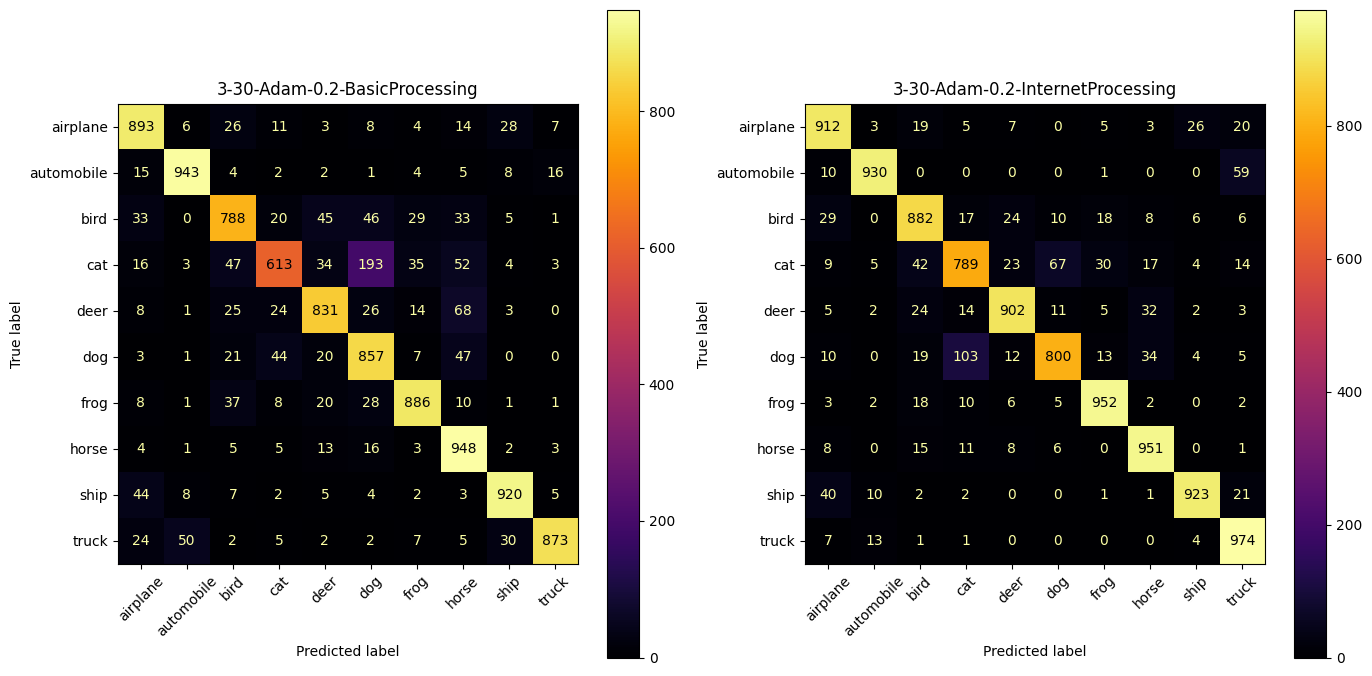

In [61]:
model1 = ResNetLayer(3)
model1.load_state_dict(torch.load('./models/ResNet18/3-30-Adam-0.2.pth', weights_only=True))

model2 = ResNetLayer(3)
model2.load_state_dict(torch.load('./models/ResNet18/3-30-Adam-0.2-InternetProcessing.pth', weights_only=True))


model_names = ['3-30-Adam-0.2-BasicProcessing', '3-30-Adam-0.2-InternetProcessing']
display_matrices(model_names, *get_predictions(model1, val_loader, device), *get_predictions(model2, val_loader, device))

Cats and dogs are still tricky compared to the other classes, but that’s a big improvement. Not only have those classes improved, but so have all the others. We could test different architectures again or fine-tune the parameters. 90% accuracy is good enough for this project, so we’ll stop here for now.

It's time to upload differents online images to test our model!

In [91]:
def test_image(image_path):
    img = Image.open(image_path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    

    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    
    processing = v2.Compose([
        v2.Resize((32, 32)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=mean, std=std)
    ]) 
    
    img = processing(img)
    img = img.unsqueeze(0) # Batch dimension

    model = ResNetLayer(3)
    model.load_state_dict(torch.load('./models/ResNet18/3-10-Adam-0.2-InternetProcessing.pth', weights_only=True))
    
    return model.predict(img)

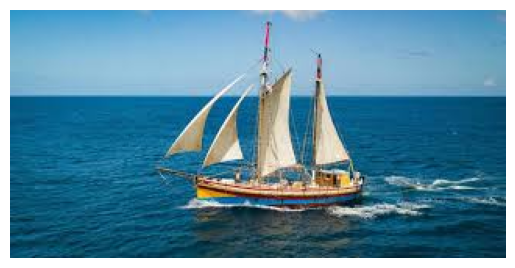

('ship', {'airplane': '0.00', 'automobile': '0.00', 'bird': '0.00', 'cat': '0.00', 'deer': '0.00', 'dog': '0.00', 'frog': '0.00', 'horse': '0.00', 'ship': '100.00', 'truck': '0.00'})



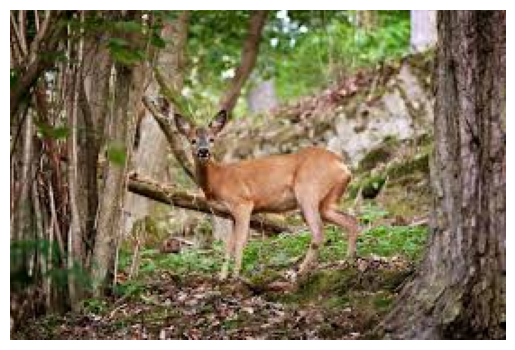

('deer', {'airplane': '0.00', 'automobile': '0.00', 'bird': '1.27', 'cat': '0.92', 'deer': '96.89', 'dog': '0.18', 'frog': '0.61', 'horse': '0.11', 'ship': '0.00', 'truck': '0.01'})



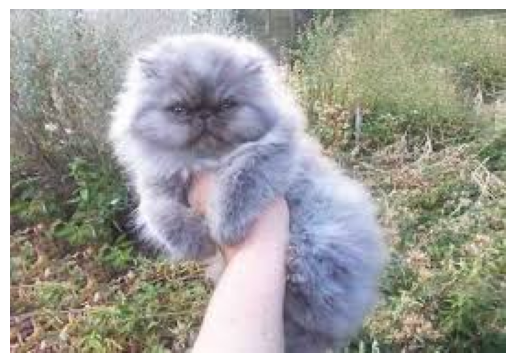

('bird', {'airplane': '0.00', 'automobile': '0.00', 'bird': '91.70', 'cat': '0.81', 'deer': '0.30', 'dog': '6.84', 'frog': '0.03', 'horse': '0.30', 'ship': '0.00', 'truck': '0.01'})



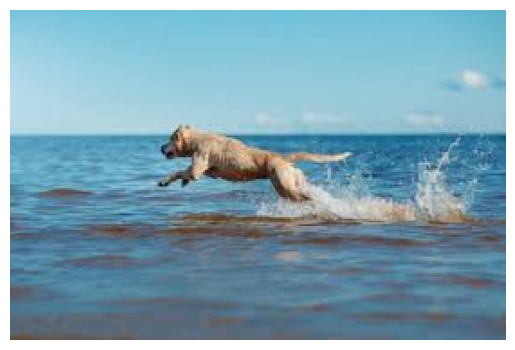

('ship', {'airplane': '0.82', 'automobile': '0.00', 'bird': '0.24', 'cat': '0.08', 'deer': '0.39', 'dog': '0.09', 'frog': '0.01', 'horse': '0.04', 'ship': '98.33', 'truck': '0.00'})



In [104]:
image_paths = [
    Path('./data/upload/boat.jpeg'),
    Path('./data/upload/dear.jpeg'),
    Path('./data/upload/cat.jpeg'),
    Path('./data/upload/dog.jpeg'),
]

for img_path in image_paths:
    result = test_image(img_path)
    print(result)
    print()

The model definitely shows its limits with the last images. However, these pictures reveals a lot about the model's prediction. It classifies them due to their surroundings. Perhaps if we can find a way to accurately identify the object, we could improve our results? That’s exactly what we plan to do in a future project: **segmentation**!